<a href="https://www.kaggle.com/code/mk9455/textclassification-logisticregression?scriptVersionId=104711196" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Ignore Future Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [103]:
dataset = pd.read_csv("../input/trainedosha-data/TrainedOSHAData.csv")
dataset.shape

(4847, 13)

In [104]:
dataset.head()

,Event Date,Abstract_Text,Event Description,Event Keywords,Construction End Use,Project Type,Degree_of_Injury,Nature_of_Injury,Part_of_Body,Event_Type,Environmental_Factor,Human_Factor,Task_Assigned
0,08-10-2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",,,Nonfatal,"Amputation, Crushing",Fingers,Caught in or between,Catch Point/Puncture Action,Other,Regularly Assigned
1,7/17/2017,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",Other building,Alteration or rehabilitation,Nonfatal,Dislocation,Fingers,Caught in or between,Other,Position Inappropriate For Task,Regularly Assigned
2,6/30/2017,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",,,Nonfatal,Fire Burn,Hand,Other,Other,Malfunction In Securing/Warning Op,Not Regularly Assigned
3,6/30/2017,"At 2:00 p.m. on June 30, 2017, an employee was...",EMPLOYEE FALLS FROM ROOF AND IS INJURED,"RIB,ROOF,HEAD,FALL PROTECTION,FALL,COLLARBONE,...",Commercial building,Alteration or rehabilitation,Fatal,Serious Fall/Strike,Head,Fall (from elevation),Work-Surface/Facility-Layout Condition,Other,Regularly Assigned
4,6/23/2017,"At 12:20 p.m. on June 23, 2017, an employee wa...",EMPLOYEE IS STRUCK BY PLYWOOD WHILE UNLOADING ...,"STRUCK BY,TRUCK,BRAIN,NECK,FRACTURE,UNSTABLE LOAD",,,Nonfatal,"Bruising, Contusion",Neck,Struck-by,Overhead Moving/Falling Object Action,Insufficient/Lack/Housekeeping Program,Regularly Assigned


In [105]:
from gensim import utils
import smart_open
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.remove_stopwords ,
           gsp.strip_short,
           gsp.stem_text
          ]

def clean_text(dataset):
    dataset = dataset.lower()
    dataset = utils.to_unicode(dataset)
    for f in filters:
        dataset = f(dataset)
    return dataset

dataset["clean_text"] = dataset["Abstract_Text"].apply(clean_text)
#dataset.head()

In [106]:
dataset.iloc[1,1]

"At 9:45 a.m. on July 17, 2017, an employee was using a battery operated drill to drill a hole on a wooden joist about 109 inches above the floor. The employee's right hand slipped from a drill grip, and the tip of his right hand glove got caught in the drill head. The entanglement caused amputation of the right ring finger. to drill a hole on a wooden joist about 109 inches above the floor. The employee's right hand slipped from a drill grip, and the tip of his right hand glove got caught in the drill head. The entanglement caused amputation of the right ring finger. "

In [107]:
clean_text(dataset.iloc[1,1])

'juli 2017 employe batteri oper drill drill hole wooden joist 109 inch floor employe right hand slip drill grip tip right hand glove got caught drill head entangl caus amput right ring finger drill hole wooden joist 109 inch floor employe right hand slip drill grip tip right hand glove got caught drill head entangl caus amput right ring finger'

## Degree of Injury - Fatal/Non-fatal

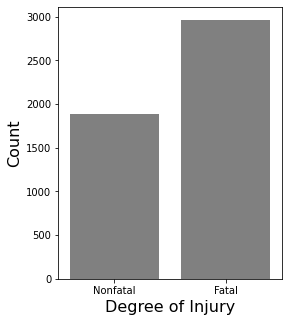

In [108]:
#print(dataset['Degree_of_Injury'].value_counts())
plt.figure(figsize=(4,5))
sns.countplot(x=dataset.Degree_of_Injury, color='gray')
#plt.title('Degree of Injury', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Degree of Injury', fontsize=16)
plt.xticks();
plt.show()

In [109]:
dataset['Degree_of_Injury'] = dataset.Degree_of_Injury.factorize()[0]
dataset.head()

,Event Date,Abstract_Text,Event Description,Event Keywords,Construction End Use,Project Type,Degree_of_Injury,Nature_of_Injury,Part_of_Body,Event_Type,Environmental_Factor,Human_Factor,Task_Assigned,clean_text
0,08-10-2017,"At 9:00 a.m. on August 10, 2017, an employee w...",EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...,"FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD",,,0,"Amputation, Crushing",Fingers,Caught in or between,Catch Point/Puncture Action,Other,Regularly Assigned,august 2017 employe oper 400 ton bliss coin kn...
1,7/17/2017,"At 9:45 a.m. on July 17, 2017, an employee was...",EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...,"CAUGHT IN,DRIVE SHAFT,RESIDENTIAL CONSTRUCTION...",Other building,Alteration or rehabilitation,0,Dislocation,Fingers,Caught in or between,Other,Position Inappropriate For Task,Regularly Assigned,juli 2017 employe batteri oper drill drill hol...
2,6/30/2017,"At 7:30 a.m. on June 30, 2017, an employee was...",EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...,"AMPUTATED,EXPLOSION,FIREWORKS",,,0,Fire Burn,Hand,Other,Other,Malfunction In Securing/Warning Op,Not Regularly Assigned,june 2017 employe insert match fuze firework c...
3,6/30/2017,"At 2:00 p.m. on June 30, 2017, an employee was...",EMPLOYEE FALLS FROM ROOF AND IS INJURED,"RIB,ROOF,HEAD,FALL PROTECTION,FALL,COLLARBONE,...",Commercial building,Alteration or rehabilitation,1,Serious Fall/Strike,Head,Fall (from elevation),Work-Surface/Facility-Layout Condition,Other,Regularly Assigned,june 2017 employe instal self adher membran ro...
4,6/23/2017,"At 12:20 p.m. on June 23, 2017, an employee wa...",EMPLOYEE IS STRUCK BY PLYWOOD WHILE UNLOADING ...,"STRUCK BY,TRUCK,BRAIN,NECK,FRACTURE,UNSTABLE LOAD",,,0,"Bruising, Contusion",Neck,Struck-by,Overhead Moving/Falling Object Action,Insufficient/Lack/Housekeeping Program,Regularly Assigned,june 2017 employe deliv load plywood project s...


In [110]:
dataset.skew(axis=0)

Degree_of_Injury   -0.457716
dtype: float64

In [111]:
dataset.kurtosis()

Degree_of_Injury   -1.791236
dtype: float64

In [112]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['degree_id'] = labelEncoder.fit_transform(dataset['Degree_of_Injury'])
print(dataset['degree_id'].value_counts())

1    2964
0    1883
Name: degree_id, dtype: int64


In [113]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["degree_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [114]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [115]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  95.1890034364261
[1 1 1 ... 1 0 1]


[[522  42]
 [ 28 863]]


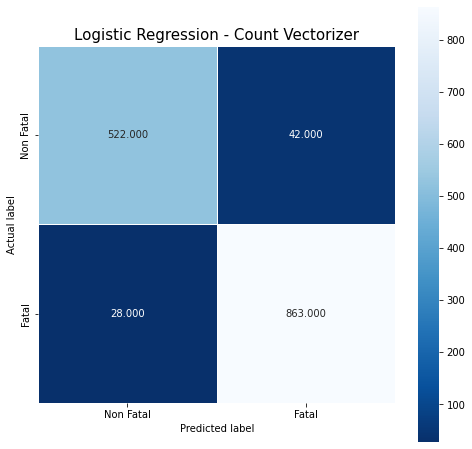

In [116]:
cm=metrics.confusion_matrix(test_labels, y_pred=predLogReg1)
print(cm)

plt.figure(figsize=(8,8))
axis_labels=["Non Fatal", "Fatal"]
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=axis_labels, yticklabels = axis_labels);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title("Logistic Regression - Count Vectorizer", size = 15);

In [117]:
p = precision_score(test_labels, predLogReg1)
r = recall_score(test_labels, predLogReg1)
f = fbeta_score(test_labels, predLogReg1, beta=2.0)
print('Precision = %.3f' % (p*100))
print('Recall = %.3f'% (r*100))
print('F2 Score = %.3f'% (f*100))

Precision = 95.359
Recall = 96.857
F2 Score = 96.554


In [118]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  94.36426116838487
[1 1 1 ... 1 0 1]


[[499  65]
 [ 17 874]]


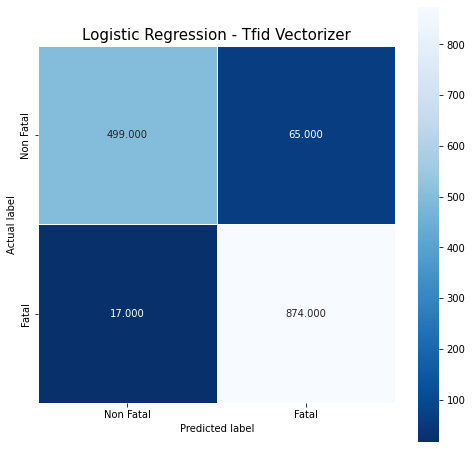

In [119]:
cm=metrics.confusion_matrix(y_true=test_labels, y_pred=predLogReg2)
print(cm)
plt.figure(figsize=(8, 8))
#axis_labels=["Non Fatal", "Fatal"]
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=axis_labels, yticklabels = axis_labels);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score2)
plt.title("Logistic Regression - Tfid Vectorizer", size = 15);

In [120]:
p = precision_score(test_labels, predLogReg2)
r = recall_score(test_labels, predLogReg2)
f = fbeta_score(test_labels, predLogReg2, beta=2.0)
print('Precision = %.3f' % (p*100))
print('Recall = %.3f'% (r*100))
print('F2 Score = %.3f'% (f*100))

Precision = 93.078
Recall = 98.092
F2 Score = 97.046


## Nature of Injury

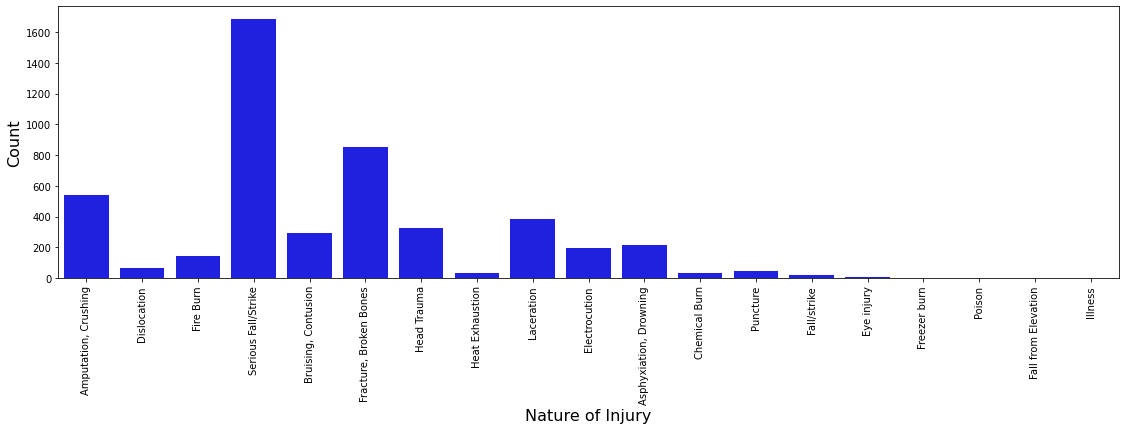

In [121]:
#print(dataset['Nature_of_Injury'].value_counts())
plt.figure(figsize=(19,5))
sns.countplot(x=dataset.Nature_of_Injury, color='blue')
plt.ylabel('Count', fontsize=16)
plt.xlabel('Nature of Injury', fontsize=16)
plt.xticks(rotation='vertical');
plt.show()

In [122]:
# Converting the catergory labels into numeric values using Encoder
dataset['Nature_of_Injury'] = dataset.Nature_of_Injury.factorize()[0]
labelEncoder = preprocessing.LabelEncoder()
dataset['nature_id'] = labelEncoder.fit_transform(dataset['Nature_of_Injury'])
print(dataset['nature_id'].value_counts())

4     1683
6      852
1      542
9      382
7      328
5      291
11     213
10     199
3      144
2       64
13      48
8       32
12      31
14      23
15       6
17       4
0        2
16       1
18       1
19       1
Name: nature_id, dtype: int64


In [123]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["nature_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [124]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [125]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  57.0446735395189
[4 4 4 ... 4 6 7]


[[  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 136   1   0   4   0   1   0   0  14   0   0   1   0   0   0   0]
 [  0   0   1   0  11   1   5   1   0   1   0   1   0   0   0   0   0]
 [  0   1   0  29   7   0   0   0   0   1   1   0   0   0   0   0   0]
 [  0   0   1   0 381  16  48  31   1  14   2   8   0   1   0   0   0]
 [  0   2   0   0  37  10  24  11   0   2   0   0   0   0   0   0   0]
 [  0   4   0   0  83  11 136  21   0  18   0   3   0   0   1   0   0]
 [  0   0   0   0  41   7  11  16   0   7   0   0   0   0   0   0   0]
 [  0   0   0   0   9   0   0   0   2   0   0   0   0   0   0   0   0]
 [  0  13   0   2  21   5  21   3   0  49   2   2   0   0   0   0   0]
 [  0   0   0   5   8   0   0   1   0   1  46   0   0   0   0   0   0]
 [  0   0   0   0  35   2   4   0   1   0   0  23   1   0   0   0   1]
 [  0   0   0   5   2   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   5   1   5   1   0   3   0   1   0   0   0   0   0]
 [  0 

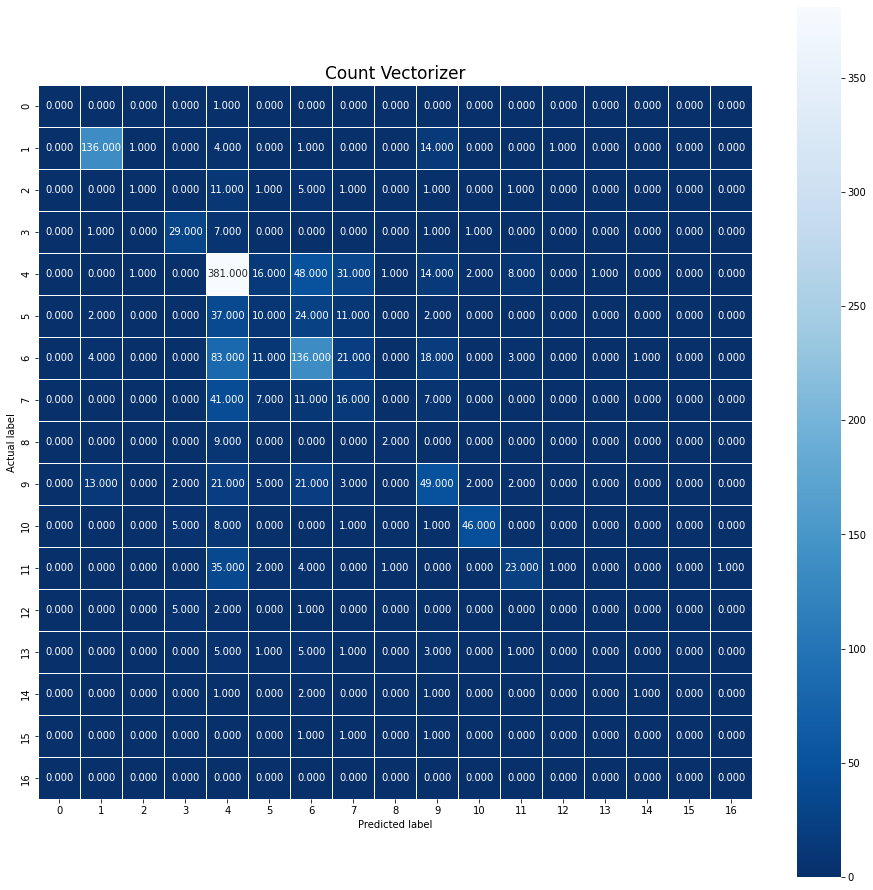

In [126]:
cm=metrics.confusion_matrix(test_labels, predLogReg1)
print(cm)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title('Count Vectorizer', size = 17);

In [127]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  60.06872852233677
[4 4 4 ... 4 6 4]


[[  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0 144   0   0   9   0   3   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0  14   0   7   0   0   0   0   0   0   0   0   0]
 [  0   2   0  23  11   0   1   0   0   0   2   0   0   0   0   0]
 [  0   1   0   0 472   0  20   4   0   4   2   0   0   0   0   0]
 [  0   2   0   0  56   0  25   2   0   1   0   0   0   0   0   0]
 [  0   5   0   0 117   1 146   4   0   4   0   0   0   0   0   0]
 [  0   0   0   0  56   2  16   6   0   2   0   0   0   0   0   0]
 [  0   0   0   0  11   0   0   0   0   0   0   0   0   0   0   0]
 [  0  16   0   2  50   0  19   0   0  31   0   0   0   0   0   0]
 [  0   0   0   4  13   0   1   0   0   0  43   0   0   0   0   0]
 [  0   0   0   0  58   0   0   0   0   0   0   9   0   0   0   0]
 [  0   0   0   6   2   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  11   0   4   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   1   0   4   0   0   0   0   0   0   0   0 

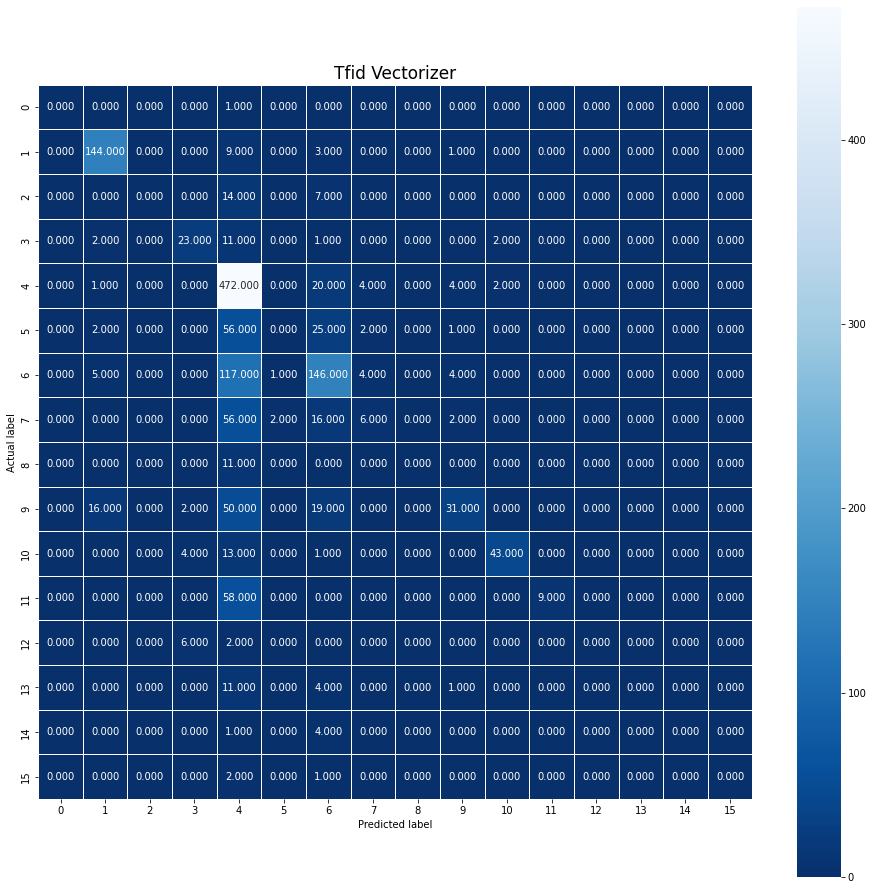

In [128]:
cm=metrics.confusion_matrix(test_labels, predLogReg2)
print(cm)
plt.figure(figsize=(16,16))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title('Tfid Vectorizer', size = 17);

## Event Type

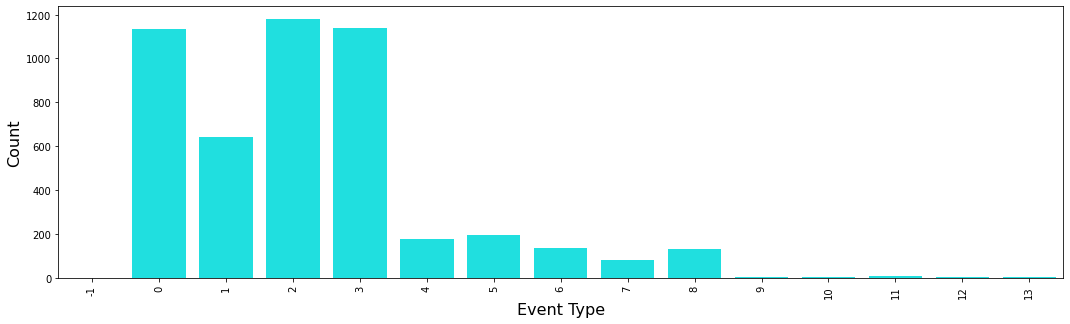

In [129]:
dataset['Event_Type'] = dataset.Event_Type.factorize()[0]
#print(dataset['Event_Type'].value_counts())
plt.figure(figsize=(18,5))
sns.countplot(x=dataset.Event_Type, color='cyan')
#plt.title('Event Type', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Event Type', fontsize=16)
plt.xticks(rotation='vertical');
plt.show()

In [130]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['event_id'] = labelEncoder.fit_transform(dataset['Event_Type'])
#print(dataset['event_id'].value_counts())

In [131]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["event_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [132]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [133]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  69.0721649484536
[4 2 2 ... 3 3 4]


In [134]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  69.89690721649484
[4 2 4 ... 3 3 4]


## Task Assigned

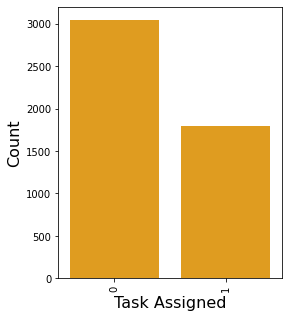

In [135]:
dataset['Task_Assigned'] = dataset.Task_Assigned.factorize()[0]
#print(dataset['Task_Assigned'].value_counts())
plt.figure(figsize=(4,5))
sns.countplot(x=dataset.Task_Assigned, color='orange')
#plt.title('Task Assigned', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Task Assigned', fontsize=16)
plt.xticks(rotation='vertical');
plt.show()

In [136]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['task_assigned_id'] = labelEncoder.fit_transform(dataset['Task_Assigned'])
print(dataset['task_assigned_id'].value_counts())

0    3048
1    1799
Name: task_assigned_id, dtype: int64


In [137]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["task_assigned_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [138]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [139]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  59.03780068728523
[1 1 1 ... 1 0 1]


[[661 279]
 [317 198]]


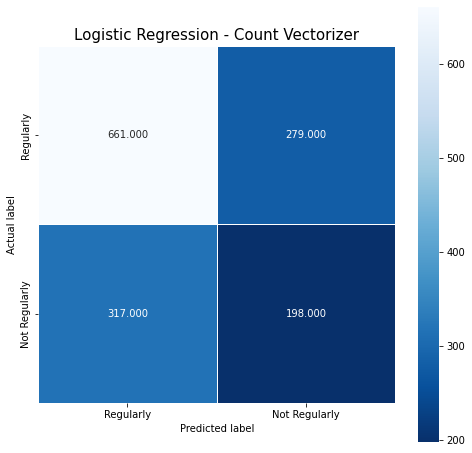

In [140]:
cm=metrics.confusion_matrix(y_true=test_labels, y_pred=predLogReg1)
print(cm)

plt.figure(figsize=(8,8))
axis_labels=["Regularly", "Not Regularly"]
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=axis_labels, yticklabels = axis_labels);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title('Logistic Regression - Count Vectorizer', size = 15);

In [141]:
def precision(cm):
    true_positive = cm[0][0]
    false_positive = cm[1][0]
    p = true_positive/(true_positive+false_positive)
    return p
    
def recall(cm):
    true_positive = cm[0][0]
    false_negative = cm[0][1]
    r = true_positive/(true_positive+false_negative)
    return r

def f2_score(precision, recall):
    f2 = (5*precision*recall)/(4*precision+recall)
    return f2

In [142]:
p = precision(cm)
r = recall(cm)
f = f2_score(p, r)
print('Precision = %.3f' % (p*100))
print('Recall = %.3f'% (r*100))
print('F2 Score = %.3f'% (f*100))

Precision = 67.587
Recall = 70.319
F2 Score = 69.755


In [143]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  63.91752577319587
[0 1 0 ... 0 0 0]


[[829 111]
 [414 101]]


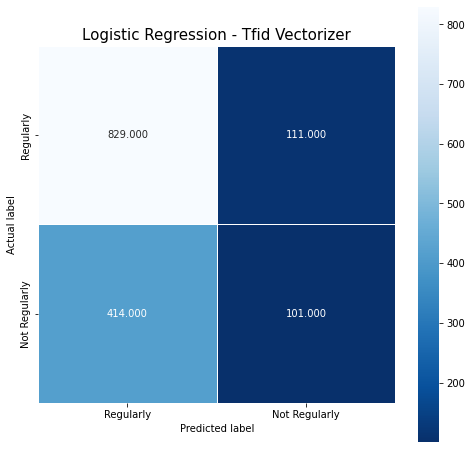

In [144]:
cm=metrics.confusion_matrix(y_true=test_labels, y_pred=predLogReg2)
print(cm)

plt.figure(figsize=(8,8))
axis_labels=["Regularly", "Not Regularly"]
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=axis_labels, yticklabels = axis_labels);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title('Logistic Regression - Tfid Vectorizer', size = 15);

In [145]:
p = precision(cm)
r = recall(cm)
f = f2_score(p, r)
print('Precision = %.3f' % (p*100))
print('Recall = %.3f'% (r*100))
print('F2 Score = %.3f'% (f*100))

Precision = 66.693
Recall = 88.191
F2 Score = 82.850


## Part of Body

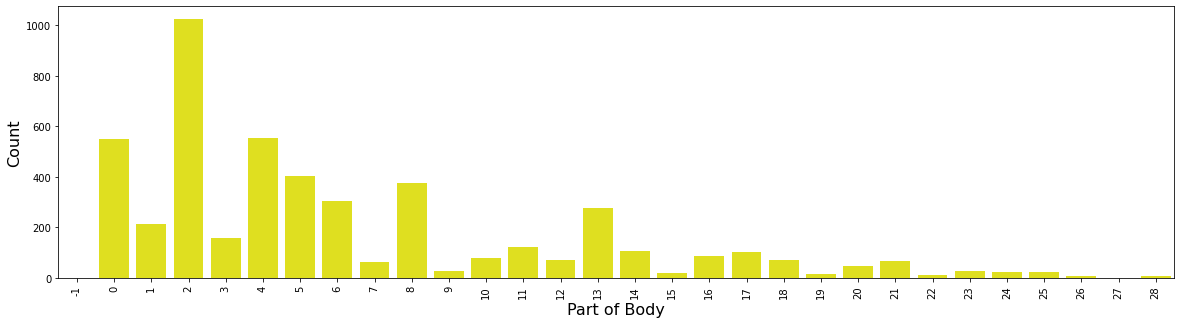

In [146]:
dataset['Part_of_Body'] = dataset.Part_of_Body.factorize()[0]
#print(dataset['Part_of_Body'].value_counts())
plt.figure(figsize=(20,5))
sns.countplot(x=dataset.Part_of_Body, color='yellow')
#plt.title('Task Assigned', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Part of Body', fontsize=16)
plt.xticks(rotation='vertical');
plt.show()

In [147]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['part_id'] = labelEncoder.fit_transform(dataset['Part_of_Body'])
#print(dataset['part_id'].value_counts())

In [148]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["part_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [149]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [150]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  45.36082474226804
[ 5  7  5 ...  3 14 18]


In [151]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  47.14776632302405
[ 5  7  5 ...  3 14 18]


## Environmental Factor

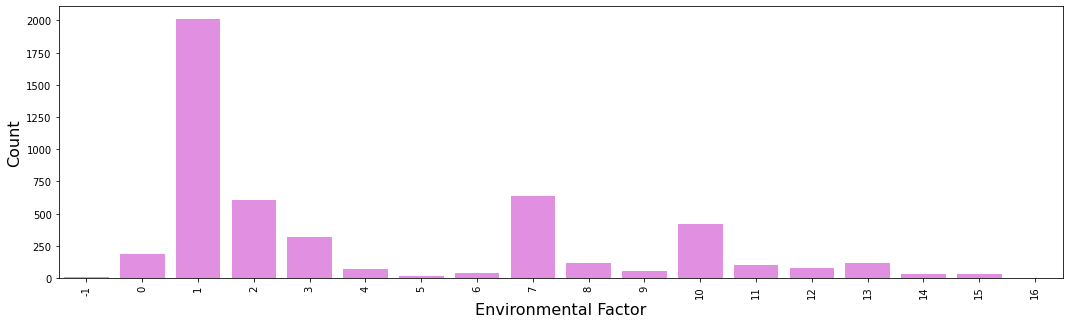

In [152]:
dataset['Environmental_Factor'] = dataset.Environmental_Factor.factorize()[0]
#print(dataset['Environmental_Factor'].value_counts())
plt.figure(figsize=(18,5))
sns.countplot(x=dataset.Environmental_Factor, color='violet')
#plt.title('Task Assigned', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Environmental Factor', fontsize=16)
plt.xticks(rotation='vertical');
plt.show()

In [153]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['ef_id'] = labelEncoder.fit_transform(dataset['Environmental_Factor'])
print(dataset['ef_id'].value_counts())

2     2009
8      635
3      608
11     422
4      320
1      187
14     114
9      114
12     105
13      80
5       73
10      51
7       40
16      34
15      33
6       13
0        7
17       2
Name: ef_id, dtype: int64


In [154]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["ef_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [155]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [156]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  45.223367697594504
[2 2 2 ... 3 3 4]


In [157]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  47.97250859106529
[2 2 2 ... 2 2 2]


## Human Factor

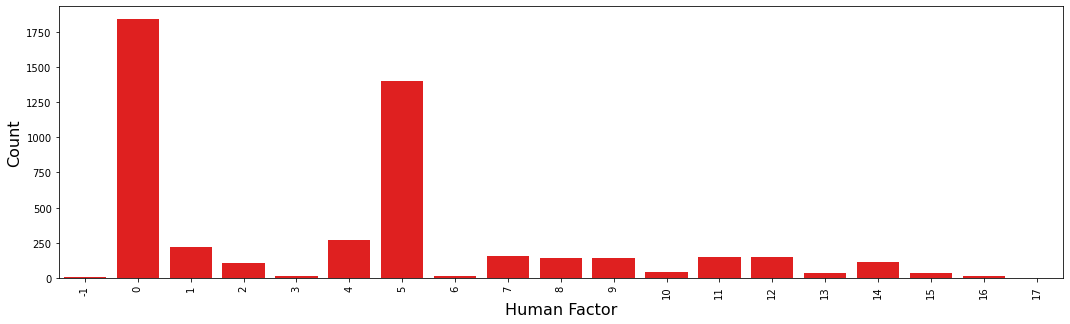

In [158]:
dataset['Human_Factor'] = dataset.Human_Factor.factorize()[0]
#print(dataset['Human_Factor'].value_counts())
plt.figure(figsize=(18,5))
sns.countplot(x=dataset.Human_Factor, color='red')
#plt.title('Task Assigned', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Human Factor', fontsize=16)
plt.xticks(rotation='vertical');
plt.show()

In [159]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['hf_id'] = labelEncoder.fit_transform(dataset['Human_Factor'])
#print(dataset['hf_id'].value_counts())

In [160]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["clean_text"], dataset["hf_id"], train_size=0.7, random_state=5)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (3392,)
Train y size : (3392,)
Test x size : (1455,)
Test y size : (1455,)


In [161]:
# Extracting features by counting word counts
countVector = CountVectorizer(min_df=2)
countVector.fit_transform(train_text)
trainFeatureSet = countVector.transform(train_text)
testFeatureSet = countVector.transform(test_text)
testFeatureSet.shape

(1455, 3119)

In [162]:
#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(trainFeatureSet,train_labels)

# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(testFeatureSet)
score = logRegModel.score(testFeatureSet,test_labels)
print("Approximate Accuracy with countVectorizer : ", score*100)
print(predLogReg1)

Approximate Accuracy with countVectorizer :  36.21993127147766
[1 1 1 ... 1 6 6]


In [163]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(max_iter=1000)
logRegModel2.fit(tfidTrainFeatures,train_labels)

# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf : ", score2*100)
print(predLogReg2)

Approximate Accuracy with TfIdf :  40.06872852233677
[1 1 1 ... 1 6 6]


### Testing

In [164]:
dataset.iloc[8,1]

'At 5:15 p.m. on May 31, 2017, an employee was applying adhesive to insulated foam board for wall siding operation.  The employee tripped over a 24 inch by 48 inch skylight that was covered with original manufactured plastic bubble cover and fell through it.  The employee fell approximately 30 feet before striking the concrete floor.  The employee sustained blunt force trauma to the head and body and was killed. '

In [165]:
test_text = clean_text(dataset.iloc[8,1])

In [166]:
#testFeatureSet = countVector.transform(manual_test_text)